<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_LangGraph_Exercise/blob/main/AI_for_BI/sql_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this SQL Agent

* After a user typed in a query, the agent is able to
  * locate the tables
  * write the SQL query to answer user's question
  * execute the SQL query and rewrite the SQL query until LLM thinks it gets the correct output

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_openai langchain_community

In [2]:
from google.colab import userdata

# load the environment variables set in colab
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# About the Data

* This is a SQLite example database "chinook", it has multiple tables: `['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']`

In [3]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [4]:
from langchain_community.utilities import SQLDatabase
import pandas as pd
import pprint
import json
import ast


db = SQLDatabase.from_uri("sqlite:///Chinook.db")  # load the downloaded DB
print(db.dialect)
all_table_names = db.get_usable_table_names()
print('All the Usable Tables:', all_table_names)
print()

print('Data Sample from Table Customer:')
sample = ast.literal_eval(db.run("SELECT * FROM Customer LIMIT 5;"))
columns_query = """SELECT name FROM pragma_table_info('Customer')"""
cols = db.run(columns_query)
sample_df = pd.DataFrame(sample, columns=[col[0] for col in ast.literal_eval(cols)])
display(sample_df)

sqlite
All the Usable Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']

Data Sample from Table Customer:


,CustomerId,FirstName,LastName,Company,Address,City,State,Country,PostalCode,Phone,Fax,Email,SupportRepId
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
2,3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
3,4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
4,5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [5]:
all_table_schemas = {}
schema_cols = ['cid', 'name', 'type', 'notnull', 'default_value', 'pk']
for table_name in all_table_names:
    # Get schema data
    schema_query = f"PRAGMA table_info({table_name});"
    schema_result = db.run(schema_query)
    schema_data = ast.literal_eval(schema_result)

    # Combine column names and schema data
    schema = []
    for i, data in enumerate(schema_data):
        schema.append(dict(zip(schema_cols, data)))
    all_table_schemas[table_name] = schema

for k, v in all_table_schemas.items():
  print(k)
  print(v)
  break

Album
[{'cid': 0, 'name': 'AlbumId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 1}, {'cid': 1, 'name': 'Title', 'type': 'NVARCHAR(160)', 'notnull': 1, 'default_value': None, 'pk': 0}, {'cid': 2, 'name': 'ArtistId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 0}]


# Build Agent

### The State of the Agent

In [44]:
from typing import List
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    user_question: str
    previous_node: str
    selected_tables: List[str]
    written_sql: str
    executed_output: str

### Nodes & Edges

In [45]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition


model_str = "gpt-4o-mini-2024-07-18"

In [39]:
def select_tables(state):
  """
    Given user's question, LLM to select tables that can solve the problem.
  """
  print("---SELECT TABLES---")
  user_question =state['user_question']

  class list_tables(BaseModel):
        table_lst: Annotated[List[str], Field(description="A list of selected tables")]

  # LLM
  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=model_str, streaming=True)
  # LLM to output required format
  llm_with_formated_output = model.with_structured_output(list_tables)

  # Prompt
  prompt = PromptTemplate(
        template="""You're an expert of SQL to answer user's data questions. \n
        Here are the data schemas of all the tables in the database: \n\n {all_table_schemas} \n\n
        Here is the user question: {user_question} \n
        If you can find all the tables that can answer user's questions, list all the tables' names,
        otherwise output an empty list.""",
        input_variables=["all_table_schemas", "user_question"],
    )

  # Chain
  chain = prompt | llm_with_formated_output

  output = chain.invoke({"all_table_schemas": all_table_schemas,
                                   "user_question": user_question})
  output_table_lst = output.table_lst
  print(output_table_lst)
  return {"selected_tables": output_table_lst,
          "previous_node": "select_tables"}


def write_sql(state):
  """
    Given user's question and selected tables, LLM to write SQL query.
  """
  print("---WRITE SQL QUERY---")
  user_question =state['user_question']
  selected_tables = state["selected_tables"]

  msg = [
      SystemMessage(content="You are a helpful assistant that improves user questions."),
      HumanMessage(
          content=f""" \n
                  Look at the input and try to reason about the underlying semantic intent or meaning. \n
                  Here is the initial question:
                  \n ------- \n
                  {question}
                  \n ------- \n
                  Formulate an improved question: """,
      )
  ]
  model = ChatOpenAI(temperature=0,
                       model=model_str, streaming=True)
  written_query = model.invoke(msg)




def output_answer(state):
  """
    * If there's no table found in `select_tables()`, then output answer.
    * Otherwise, output the generated results.
  """
  print("---OUTPUT ANSWER---")

  if state["previous_node"] == "select_tables" and len(state['selected_tables']) == 0:
    print("Can't find any available table to solve this problem")
  else:
    print("Hanhan TEST: executed output to be added")

### Build Graph

In [40]:
from langgraph.graph import END, StateGraph, START

# define a new graph
workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("select_tables", select_tables)

# add edges
workflow.add_edge(START, "select_tables")
workflow.add_edge("select_tables", END)

# compile
graph = workflow.compile()

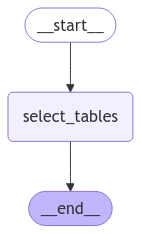

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run SQL Agent

In [42]:
import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError


def run_graph(inputs):
  graph_config = RunnableConfig(recursion_limit=5)  # stop if the cycle happened 5 times still can't hit END
  try:
    for output in graph.stream(inputs, config = graph_config):
      print(output)
  except GraphRecursionError as e:
    print()
    print("Can't find the answer")

In [43]:
inputs = {
     "user_question": "Find me the unique number of customers and artists?"
}
run_graph(inputs)

---SELECT TABLES---
['Customer', 'Artist']
{'select_tables': {'selected_tables': ['Customer', 'Artist']}}


In [12]:
inputs = {
     "user_question": "How's the weather tomorrow?"
}
run_graph(inputs)

---SELECT TABLES---

{'select_tables': {'messages': ['']}}
